# Project Notebook




The task is to produce a neural process which is tailored to solve a physical system.  In this case, the physical system to be solved is the heat diffusion across a two-dimensional grid.  There are three main changes I wish to make to the standard neural process.  These are listed below, along with a brief description of their physical motivation.

#### 1. Convolutional Encoder and Decoder block 
Spatial equivariance is built into the system, since the heat diffusion function does not have a spatially dependent forcing term.  All terms are based on derivatives, which means the solution obeys spatial equivariance.  I hope to replicate this feature in the architecture, allowing for an easier learning process.
#### 2. Learning using Privileged Information
Learning using privileged information (LUPI) allows the model, while training, to have access to 'privileged information' (PI).  PI could be anything important the model should be aware of.  For example, if the total energy in the grid is conserved, imput this as PI.  When it comes to test time, the model does not have access to any PI.  The hope is that the model can infer what the PI should be (e.g. by figuring out what the total energy is and conserving it), making for a faster learning process.  There is a wide variety of PI to be used and experimented with.  A few more examples are: initial conditions, final conditions, decay constant, entropy measure.

The way the PI is implemented is through an encoder which runs separately to the usual encoder.  The PI embedding is then aggregated with the embedding of the data using a residual neural network; we do not want the PI to dominate the learning, but merely to add a `first order correction' to the learning process.  The good thing about this structure is that the PI can be added to any encoder block (e.g. flat encoder or convolutional encoder)

#### 3. Time-Order Respecting Aggregator
In a neural process, the embeddings of the data at different times, $t_i$, are aggregated with a permutation invariant aggregator.  This is not usually useful for physical processes, as there tends to be a time-respecting process such as increase in entropy (in this case, diffusion of heat).  Therefore, it might be useful to reflect this in the aggregator.  The aggregator is such that there is no information leak from future to past - it imposes causality.

The aggregator could also be designed to reflect temporal equivariance, for the same reasons as the spatial equivariance: the diffusion equation involves no terms which depend explicitly on time, but rather only the derivative with resepct to time.  If the model is temporally equivariant, it may perform much better on extrapolation tasks (as it is not completely `blind' when it heads out of the sample, having learnt temporal behaviour)

One possible choice for this is to allow the model to `learn' these features by implementing a multi-head attention network.  However, with this option there is far less control over which physical concepts I am imposing.


I hope these three changes will improve on the most basic vanilla neural process architecture to learn the heat diffusion behaviour over a two-dimensional grid, as they are all grounded in physical concepts. 

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from scipy.integrate import odeint


# grab the neural process functions from Emilien Dupont's library called neural-processes
import sys

sys.path.insert(0, "./neural-processes")

# neural_process.py and training.py exist in neural-processes folder
import neural_process
from neural_process import NeuralProcessConv, NeuralProcess
from training import NeuralProcessTrainer
from utils import context_target_split
from heat_diffusion_dataset import Initial_Conditions, Diffusion_Data, RestoredData
from visualise import *

import matplotlib as mpl

mpl.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.size": 12,
        "figure.figsize": [8, 6],
        "lines.linewidth": 1,
        "lines.markersize": 8,
        "legend.fontsize": "medium",
        "axes.labelsize": "medium",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)



/usr/local/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/usr/local/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: (__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE)
  Referenced from: '/usr/local/lib/python3.9/site-packages/torchvision/image.so'
  Expected in: '/usr/local/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib'
  warn(f"Failed to load image Python extension: {e}")


# Diffusion Data

Heat Diffusion data was chosen as a suitable dataset to test my model.  The equation which the data follows is 

\begin{equation}
\frac{\partial u(x, y, t)}{\partial t} = D \nabla^2 u(x, y, t)
\end{equation} 

The boundary conditions are chosen to be Neumann Boundary Conditions, specifying the normal gradient to be zero at the boundaries

\begin{equation}
\left. \frac{\partial u}{\partial x} \right|_{x = 0, L} = \left. \frac{\partial u}{\partial y}\right|_{y=0, L} = 0
\end{equation}

These boundary conditions ensure heat remains inside the grid and cannot escape (the flux through the boundary is zero).  There are no sources or sinks, so the total heat energy in the grid is conserved.

The variation between datasets lies in the initial conditions.  There are three parameters for the initial conditions which are changed. 
1. Initial temperature 
2. Location of initial temperature spike
3. Broadness of initial temperature spike 

The overall heat energy in the grid therefore can change from dataset to dataset, but remains constant within each one.  The diffusion coefficient is also the same for each dataset.  This could replicate, for example, heat diffusion in a fixed medium with varying initial conditions.

Finite difference method (FDM) is used to solve equation 1.  The Laplacian is calculated using the five-point stencil finite difference method *Appendix.  This posed a difficulty when the initial conditions contained a discontinuous jump in temperature because Laplacian would become very large near the jump points.  To solve this issue, instead of implementing a different more advanced solver such as finite element methods (which may take a longer time to compute), a Gaussian filter was applied to smooth the initial conditions *Appendix.  The Gaussian filter was imported from `scipy.ndimage` module.

FDM becomes unstable when $\Delta t \leq \frac{\Delta x^2}{4D}$ *appendix, reference

In [2]:
dimensions = {
    't_dim' : 1,
    'y_dim' : 2500,
    'r_dim' : 128,
    'h_dim' : 128,
    'z_dim' : 128,
    'max_iter_time' : 500,
    'grid_size' : 50,
    'num_samples' : 40,
    'num_context' : 30,
    'num_target' : 30,
    'batch_size' : 2,
    'num_channels' : 16,
    'pi_dim' : 4
}

assert dimensions['grid_size']**2 == dimensions['y_dim']
assert dimensions['num_context'] + dimensions['num_target'] <= dimensions['max_iter_time']

# parameters
grid_size = dimensions['grid_size']
num_samples = dimensions['num_samples']
square_range = (5, 15) # side length of initial hot square
temp_range = (1.0, 2.0)
diffusion_coef = 0.25 * dimensions['max_iter_time'] # upper limit for stable FDM solver

assert diffusion_coef <= 0.25 * dimensions['max_iter_time']

In [3]:
''' 
RUN TO RE-GENERATE DATA
'''
# Abstraction classes to make data in readable format
class MetaData():
    def __init__(self, meta_data, ds_num):
        # Only access first data set in the meta-dataset 
        self.t = meta_data[ds_num][0]
        self.y = meta_data[ds_num][1]
        self.pi = meta_data[ds_num][2]

class Pi():
    def __init__(self, pi):
        self.diffusion_coef = pi[:, 0]
        self.max_temp = pi[:, 1]
        self.energy = pi[:, 2]
        self.entropy = pi[:, 3]


initial_conditions = Initial_Conditions(
    max_iter_time=dimensions['max_iter_time'], grid_size=grid_size
)

meta_data = Diffusion_Data(
    num_samples=num_samples,
    max_iter_time=dimensions['max_iter_time'],
    grid_size=grid_size,
    initial_conditions=initial_conditions,
    square_range=square_range,
    temp_range=temp_range,
    diffusion_coef=diffusion_coef,
    sigma=3
)

time_array = meta_data.time_array

# meta_data.save_tensors()

In [4]:
print(len(meta_data.data))
print(len(meta_data[0]))
print(meta_data[0][0].shape)
print(meta_data[0][1].shape)
print(meta_data[0][2].shape)

meta_data[4][2] == meta_data[3][2]

40
3
torch.Size([500, 1])
torch.Size([500, 2500])
torch.Size([500, 4])


tensor([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        ...,
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])

#### Visualize Target Data

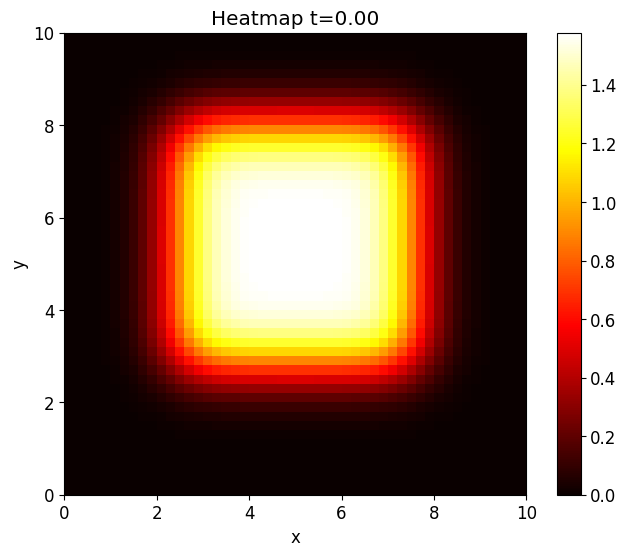

In [5]:
'''
Plot heatmap
'''

meta_data.visualise_solution(show_until=1, ds_num=3)


#### Privileged Information Data

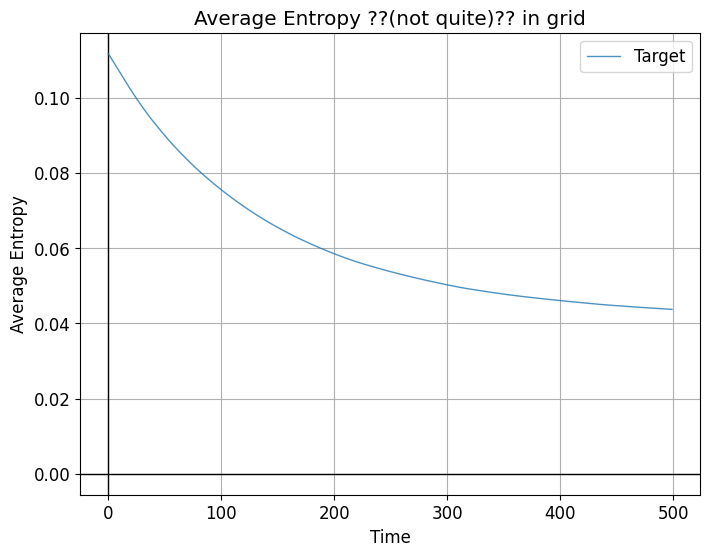

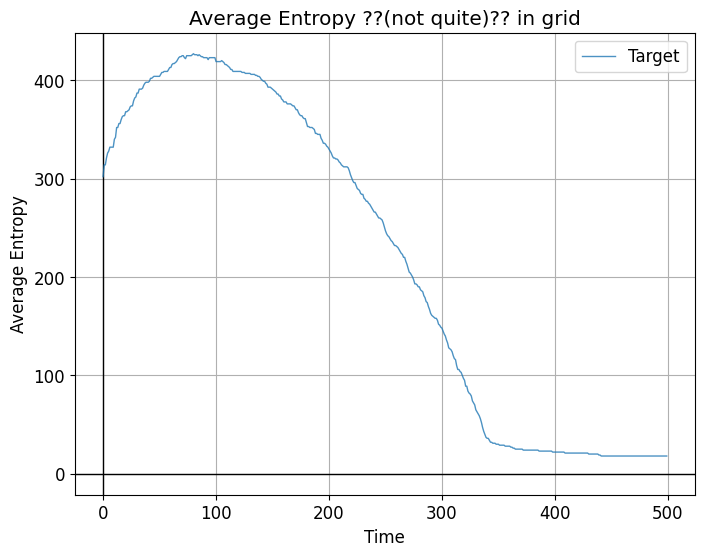

In [6]:
''' 
Plot privileged information
'''
out = torch.full((dimensions['max_iter_time'],), 0)
for ds_num in range(dimensions['num_samples']-1):
    ds = MetaData(meta_data.data, ds_num=ds_num)
    pi = Pi(ds.pi)
    out = out + pi.max_temp
out = out / dimensions['max_iter_time']

plot_energy(out, np_mean=None, lupi_mean=None, conv_mean=None, energy=False)
plot_energy(pi.entropy, np_mean=None, lupi_mean=None, conv_mean=None, energy=False)


## FLAT NEURAL PROCESS TRAINING

In [7]:
neuralprocess = NeuralProcess(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(
    "cuda",
    neuralprocess,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=200,
    is_lupi=False
)

neuralprocess.training = True
np_trainer.train(data_loader, 10)

torch.save(neuralprocess.state_dict(), './trainers/neuralprocess_dict')
torch.save(np_trainer.epoch_loss_history, './metadata/epoch_loss_history')


Epoch: 0, Avg_loss: 96997.64140625
Epoch: 1, Avg_loss: 80459.8962890625
Epoch: 2, Avg_loss: 48255.76572265625
Epoch: 3, Avg_loss: 22047.591650390626
Epoch: 4, Avg_loss: 6204.182034301758
Epoch: 5, Avg_loss: -1608.36748046875
Epoch: 6, Avg_loss: -6743.6061538696285
Epoch: 7, Avg_loss: -10404.599389648438
Epoch: 8, Avg_loss: -21971.621044921874
iteration 200, loss -42196.414
Epoch: 9, Avg_loss: -19896.93070373535


## CONVOLUTIONAL NEURAL PROCESS TRAINING

#### Hyperparameters
- h_dim
- r_dim
- z_dim
- batch_size
- num_context
- num_target
- lr

#### Hidden Hyperparameters
- Number of linear layers after convolution in Net
- Number of linear layers in TransposeConvNet
- Number of channels in Net and TransposeConvNet
- Number of layers in Net and TransposeConvNet
- Kernels, Dilations, Paddings

#### Current Convolution Summary 

Net: 2 layers with 32 'hidden' channels, followed by 3 Linear layers with h_dim hidden.

TNet: 1 Linear layer, followed by 2 transpose convolutional layers with 32 'hidden' channels.


#### Purpose of the Convolution
- Create spatially equivariant features in the grids
- Encourage principles of locality when learning
- Temporal equivariance in solution (periodicity encouraged?) - this is not happening currently as the temporal aspect only enters after the convolution

TODO: before moving on 
- Debug the conv neural process (write some tests?)
- Implement tests on standard NP 
- Compare performance  

In [8]:
""" 
TODO 
- put time into channels not flat layer DONE - also kept in flat layer
- play with hyperparams until good outcome 
"""

conv_neuralprocess = NeuralProcessConv(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(conv_neuralprocess.parameters(), lr=1e-3)
conv_np_trainer = NeuralProcessTrainer(
    "cuda",
    conv_neuralprocess,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=200,
    grid_size=dimensions['grid_size'],
)

conv_neuralprocess.training = True
conv_np_trainer.train(data_loader, 10)

torch.save(neuralprocess.state_dict(), './trainers/conv_neuralprocess_dict')
torch.save(conv_np_trainer.epoch_loss_history, './metadata/conv_epoch_loss_history')

Epoch: 0, Avg_loss: 200729.921875
Epoch: 1, Avg_loss: 106263.394140625
Epoch: 2, Avg_loss: 91053.39140625
Epoch: 3, Avg_loss: 83446.86875
Epoch: 4, Avg_loss: 79840.2306640625
Epoch: 5, Avg_loss: 76013.4
Epoch: 6, Avg_loss: 74233.53828125
Epoch: 7, Avg_loss: 71337.7611328125
Epoch: 8, Avg_loss: 69969.0671875
iteration 200, loss 66556.141
Epoch: 9, Avg_loss: 68583.65625


## L.U.P.I. FOR FLAT NP

In [9]:
neuralprocess_pi = NeuralProcess(dimensions)

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)
optimizer = torch.optim.Adam(neuralprocess_pi.parameters(), lr=3e-4)
np_trainer_pi = NeuralProcessTrainer(
    "cuda",
    neuralprocess_pi,
    optimizer,
    num_context_range=(dimensions['num_context'], dimensions['num_context']),
    num_extra_target_range=(dimensions['num_target'], dimensions['num_target']),
    print_freq=200,
    is_lupi=True
)

neuralprocess_pi.training = True
np_trainer_pi.train(data_loader, 10)

torch.save(neuralprocess.state_dict(), './trainers/neuralprocess_pi_dict')
torch.save(np_trainer_pi.epoch_loss_history, './metadata/lupi_epoch_loss_history')

Epoch: 0, Avg_loss: 94443.030859375
Epoch: 1, Avg_loss: 68065.0841796875
Epoch: 2, Avg_loss: 36845.994689941406
Epoch: 3, Avg_loss: 33834.01997680664
Epoch: 4, Avg_loss: 9989.99741821289
Epoch: 5, Avg_loss: 6031.354681396484
Epoch: 6, Avg_loss: 25603.79421081543
Epoch: 7, Avg_loss: -248.11569519042968
Epoch: 8, Avg_loss: -15426.373999023437
iteration 200, loss -25582.031
Epoch: 9, Avg_loss: -9083.129739379883


# TESTING

#### Reload Models

In [10]:
neuralprocess = NeuralProcess(dimensions)
neuralprocess.load_state_dict(torch.load('./trainers/neuralprocess_dict'))

conv_neuralprocess = NeuralProcess(dimensions)
conv_neuralprocess.load_state_dict(torch.load('./trainers/conv_neuralprocess_dict'))

neuralprocess_pi = NeuralProcess(dimensions)
neuralprocess_pi.load_state_dict(torch.load('./trainers/neuralprocess_pi_dict'))

data_loader = DataLoader(meta_data, batch_size=dimensions['batch_size'], shuffle=True)

#### Obtain Results from Test Data

In [16]:
def test_model(neuralprocess, t_context, y_context, t_target, y_target, noise=False):
    # Switch to test mode
    neuralprocess.training = False

    # Extract models' distributions over t_target and grid
    p_y_pred = neuralprocess(t_context, y_context, t_target)

    # flat NP
    y_out = p_y_pred.loc.detach().numpy()[0]
    var_out = p_y_pred.scale.detach().numpy()[0]

    # flat NP reshape
    y_out = y_out.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))
    var_out = var_out.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

    # flat NP result summary
    result = [
        (y_target[id, :, :], y_out[id, :, :], var_out[id, :, :])
        for id in range(y_target.shape[0])
    ]
    if not noise:
        return result

    else:
        predicted_mean = np.array([y_out[id, :, :] for id in range(y_target.shape[0])])
        return predicted_mean


In [18]:
# How many iterations to average the noise over 
iterations = 20

# Select which models to test
test_convolutional_neural_process = True
test_lupi_neural_process = True
test_flat_neural_process = True

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
t, y, pi = batch
t_context, y_context, _, _, _, _ = context_target_split(
    t[0:1], y[0:1], pi[0:1], dimensions['num_context'], dimensions['num_target']
)

# Create a set of target points corresponding to in-sample time range
t_target = torch.linspace(0, 1, dimensions['max_iter_time'])
t_target = t_target.unsqueeze(1).unsqueeze(0)

# Extract mean of distribution
t_out = t_target.numpy()[0]

# target output
y_target = y[0:1][0, :, :]
y_target = y_target.reshape((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']))

if test_lupi_neural_process:
    lupi_result = test_model(neuralprocess_pi, t_context, y_context, t_target, y_target)
    lupi_loss = torch.load('./metadata/lupi_epoch_loss_history')
    lupi_result_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(iterations):
        # generate random noise between 0 and 1 to feed as context
        y_noise = 1 * torch.rand(y_context.shape)
        lupi_result_noise = lupi_result_noise + torch.Tensor(test_model(neuralprocess_pi, t_context, y_noise, t_target, y_target, noise=True))
    
    lupi_result_noise = lupi_result_noise / iterations
    
    torch.save(lupi_result, "./results/lupi_result.pt")
    torch.save(lupi_result_noise, "./results/lupi_result_noise.pt")

if test_flat_neural_process:
    result = test_model(neuralprocess, t_context, y_context, t_target, y_target)
    loss = torch.load('./metadata/epoch_loss_history')
    result_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(iterations):
        # generate random noise between 0 and 1 to feed as context
        y_noise = 1 * torch.rand(y_context.shape)
        result_noise = result_noise + torch.Tensor(test_model(neuralprocess, t_context, y_noise, t_target, y_target, noise=True))
    result_noise = result_noise / iterations

    torch.save(result, "./results/np_result.pt")
    torch.save(loss, "./results/loss.pt")
    torch.save(result_noise, "./results/result_noise.pt")

if test_convolutional_neural_process:
    conv_result = test_model(conv_neuralprocess, t_context, y_context, t_target, y_target)
    conv_loss = torch.load('./metadata/conv_epoch_loss_history')
    conv_result_noise = torch.full((dimensions['max_iter_time'], dimensions['grid_size'], dimensions['grid_size']), 0)

    for iter in range(iterations):
        # generate random noise between 0 and 1 to feed as context
        y_noise = 1 * torch.rand(y_context.shape)
        conv_result_noise = conv_result_noise + torch.Tensor(test_model(conv_neuralprocess, t_context, y_noise, t_target, y_target, noise=True))
    conv_result_noise = conv_result_noise / iterations
    
    torch.save(conv_result, "./results/conv_result.pt")
    torch.save(conv_loss, "./results/conv_loss.pt")
    torch.save(conv_result_noise, "./results/conv_result_noise.pt")

#### Make sure data is in correct format

In [20]:
assert len(result) == dimensions['max_iter_time']
assert len(result[0]) == 3
assert len(lupi_result) == dimensions['max_iter_time']
assert len(lupi_result[0]) == 3
assert len(conv_result) == dimensions['max_iter_time']
assert len(conv_result[0]) == 3


assert result[0][0].shape == (grid_size, grid_size)
assert result[0][1].shape == (grid_size, grid_size)
assert result[0][2].shape == (grid_size, grid_size)

# assert result_noise[0][0].shape == (grid_size, grid_size)
# assert result_noise[0][1].shape == (grid_size, grid_size)
# assert result_noise[0][2].shape == (grid_size, grid_size)

assert lupi_result[0][0].shape == (grid_size, grid_size)
assert lupi_result[0][1].shape == (grid_size, grid_size)
assert lupi_result[0][2].shape == (grid_size, grid_size)

# assert lupi_result_noise[0][0].shape == (grid_size, grid_size)
# assert lupi_result_noise[0][1].shape == (grid_size, grid_size)
# assert lupi_result_noise[0][2].shape == (grid_size, grid_size)

assert conv_result[0][0].shape == (grid_size, grid_size)
assert conv_result[0][1].shape == (grid_size, grid_size)
assert conv_result[0][2].shape == (grid_size, grid_size)

# assert conv_result_noise[0][0].shape == (grid_size, grid_size)
# assert conv_result_noise[0][1].shape == (grid_size, grid_size)
# assert conv_result_noise[0][2].shape == (grid_size, grid_size)

# Main Results

#### Metric 1: Mean Accuracy

To test how well the model performed, we can calculate the accuracy across the grid using MSE

In [21]:
performance = Performance(
    result, dimensions)
print(
    "FLAT NP: MSE accuracy was {:.8f}, with variance {:.8f}".format(
        performance.mean_accuracy, performance.var_accuracy
    )
)

lupi_performance = Performance(lupi_result, dimensions)
print(
    "LUPI NP: MSE accuracy was {:.8f}, with variance {:.8f}".format(
        lupi_performance.mean_accuracy, lupi_performance.var_accuracy
    )
)

conv_performance = Performance(conv_result, dimensions)
print(
    "CONVOLUTION: MSE accuracy was {:.8f}, with variance {:.8f}".format(
        conv_performance.mean_accuracy, conv_performance.var_accuracy
    )
)

FLAT NP: MSE accuracy was 0.03829035, with variance 0.00199034
LUPI NP: MSE accuracy was 0.04023101, with variance 0.00218975
CONVOLUTION: MSE accuracy was 0.03710257, with variance 0.00156225


#### Metric 2: Plot Losses as Function of Epoch

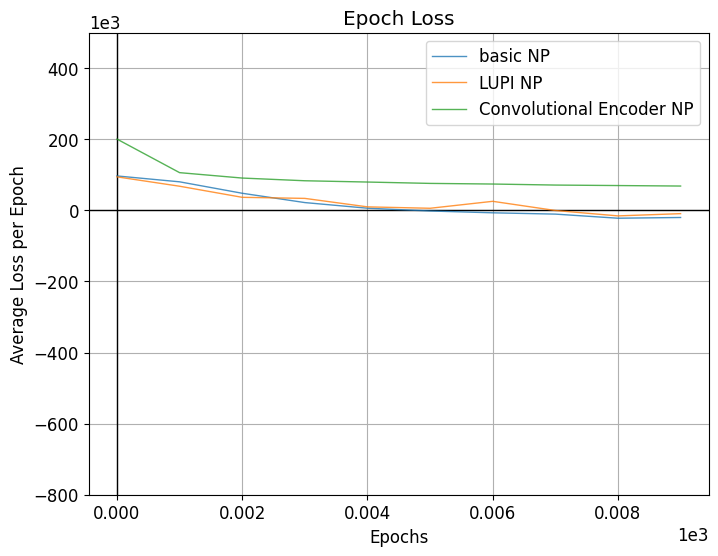

In [22]:
plot_losses(loss=loss, lupi_loss=lupi_loss, conv_loss=conv_loss, plot_moving_average=False)


#### Metric 3: Heatmaps for Comparison



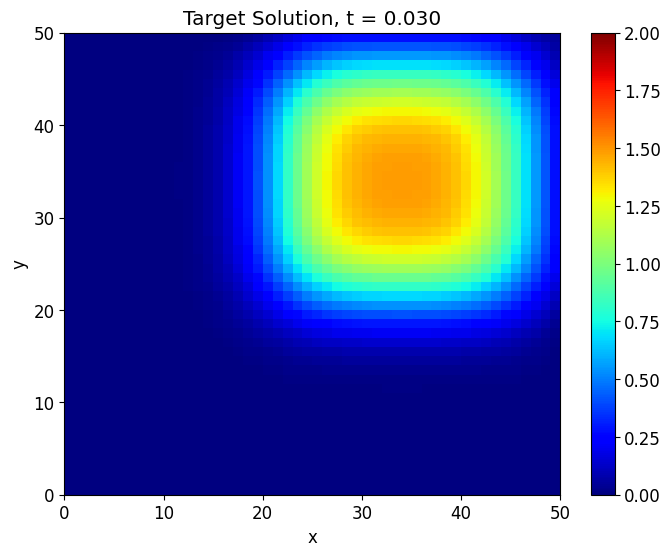

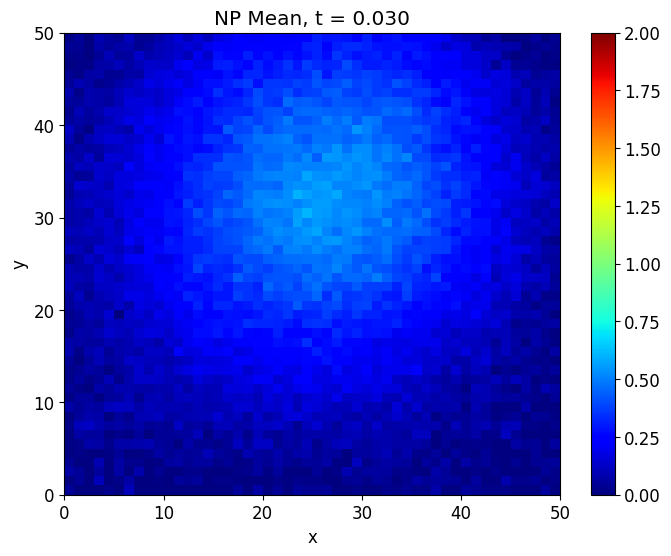

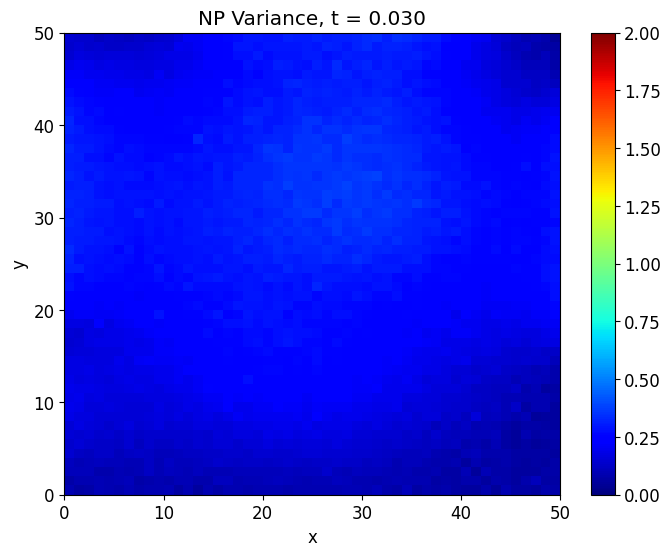

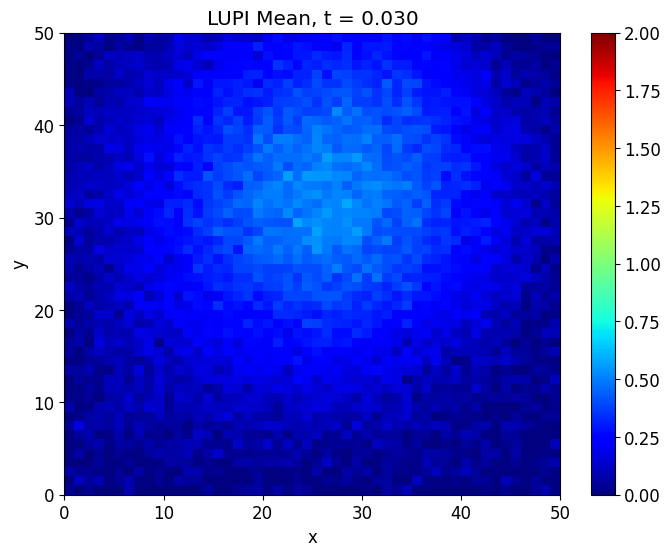

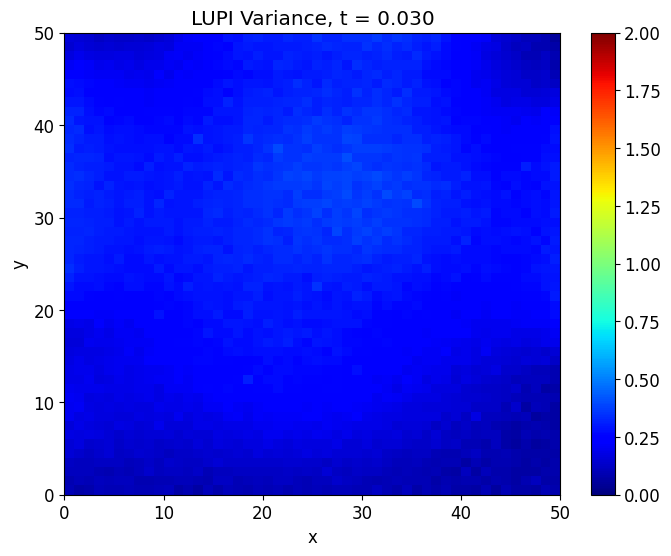

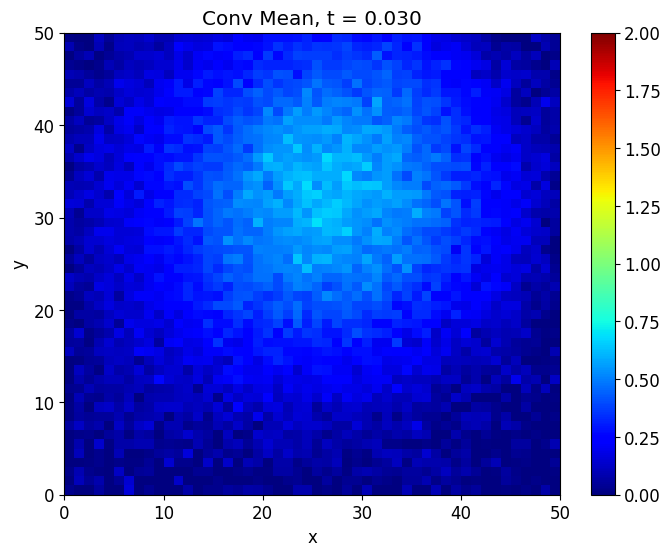

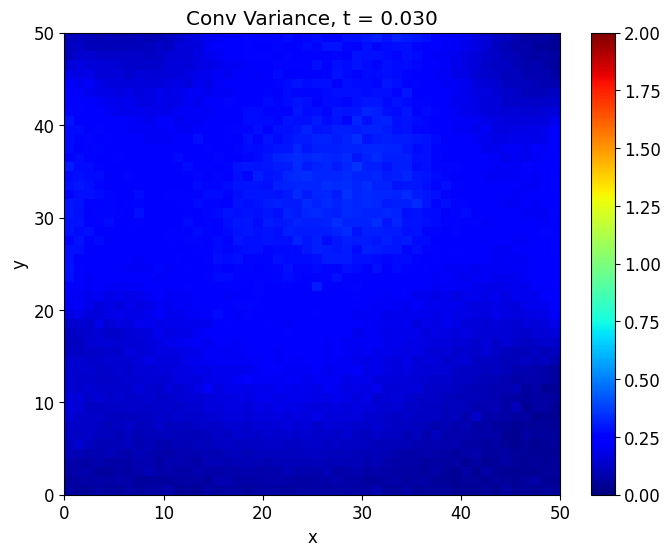

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [23]:
''' 
PLOT OF INDIVIDUAL HEATMAPS AT SPECIFIC CHOSEN TIMES 
'''
def single_hm(result_k, k: int, max_iter_time: int, which_plot: str, title=None):
    if which_plot == "Target":
        i = 0
    elif which_plot == "Mean":
        i = 1
    elif which_plot == "Variance":
        i = 2
    else:
        print("Please put either Target, Mean or Variance for argument which_plot")
        raise KeyError

    # Clear the current plot figure
    plt.clf()
    plt.xlabel("x")
    plt.ylabel("y")

    # This is to plot u_k (u at time-step k)
    if title is None:
        plt.title(
            "Temperature at t = {:.3f} unit time, {}".format(
                k / max_iter_time, which_plot
            )
        )
    else:
        plt.title("{}, t = {:.3f}".format(title, k / max_iter_time))
    plt.pcolormesh(result_k[i], cmap=plt.cm.jet, vmin=0, vmax=2.0)
    plt.colorbar()
    plt.show()
    return plt

chosen_time_step = int(15)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Target', 
    title='Target Solution'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='NP Mean'
)

single_hm(
    result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='NP Variance'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='LUPI Mean'
)

single_hm(
    lupi_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='LUPI Variance'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Mean', 
    title='Conv Mean'
)

single_hm(
    conv_result[chosen_time_step], 
    k=chosen_time_step, 
    max_iter_time=dimensions['max_iter_time'], 
    which_plot='Variance', 
    title='Conv Variance'
)


FLAT NP 



<Figure size 800x600 with 0 Axes>

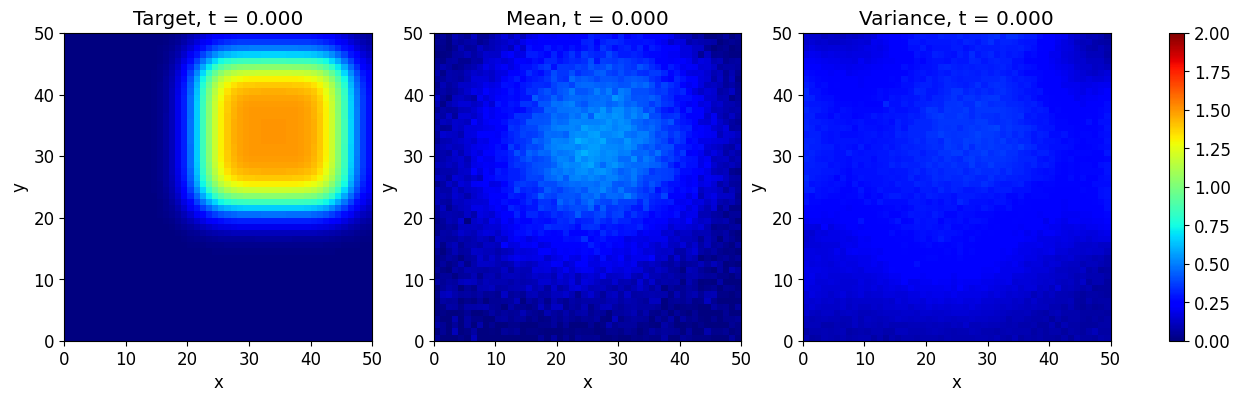

FLAT NP 



<Figure size 800x600 with 0 Axes>

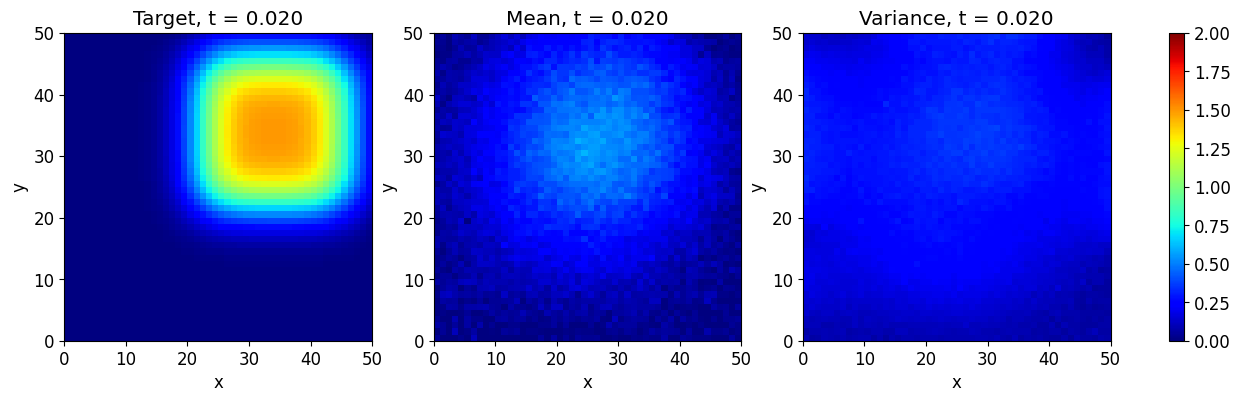

FLAT NP 



<Figure size 800x600 with 0 Axes>

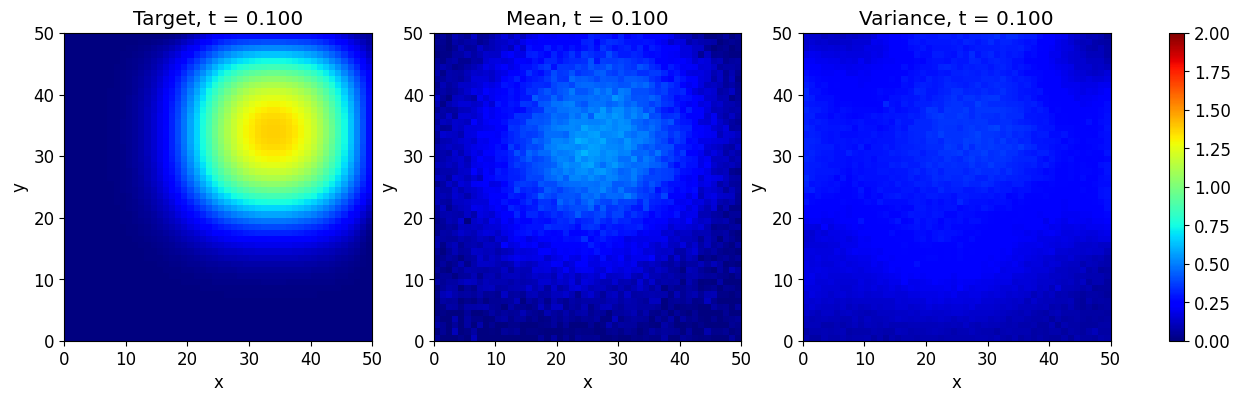

FLAT NP 



<Figure size 800x600 with 0 Axes>

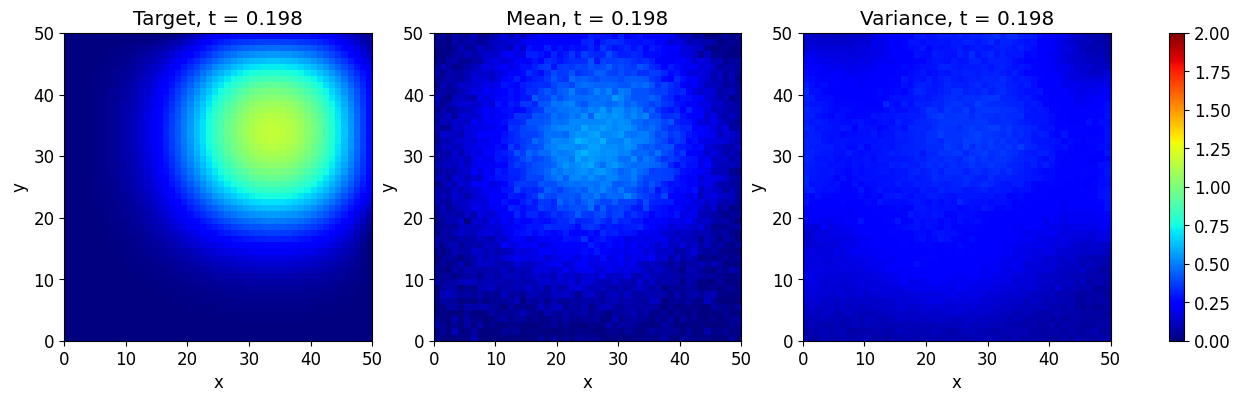




 LUPI NP 



<Figure size 800x600 with 0 Axes>

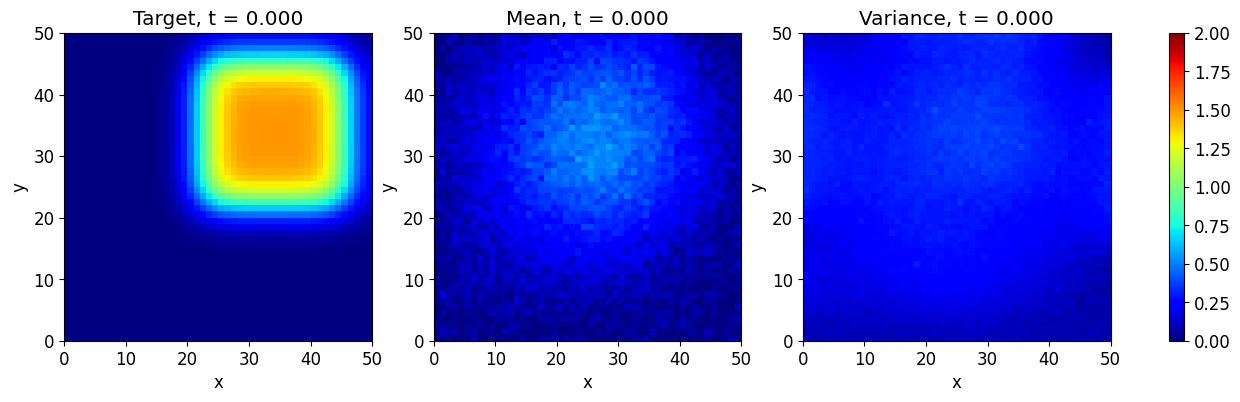




 LUPI NP 



<Figure size 800x600 with 0 Axes>

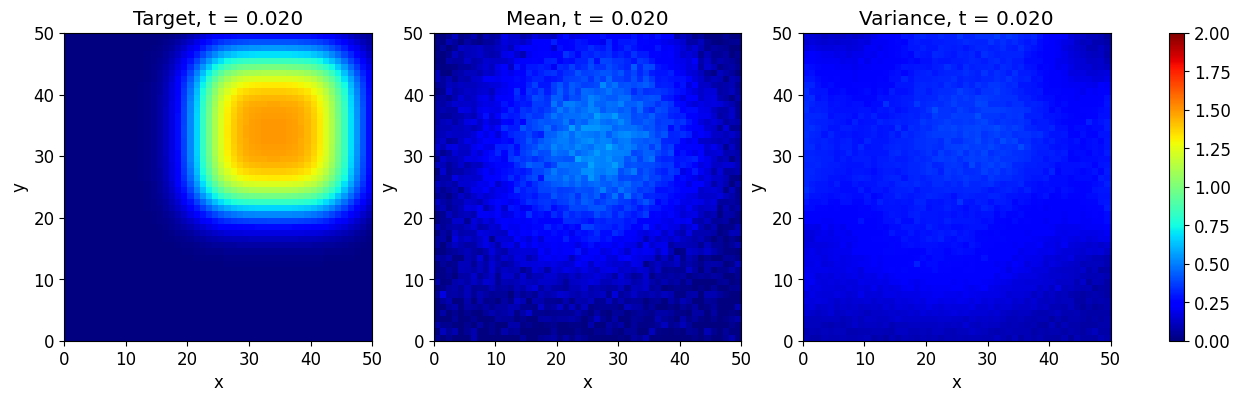




 LUPI NP 



<Figure size 800x600 with 0 Axes>

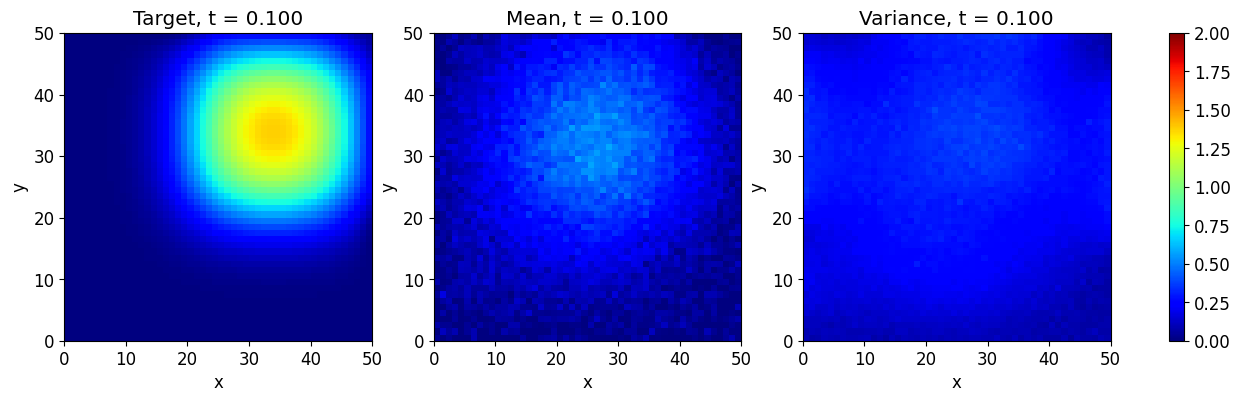




 LUPI NP 



<Figure size 800x600 with 0 Axes>

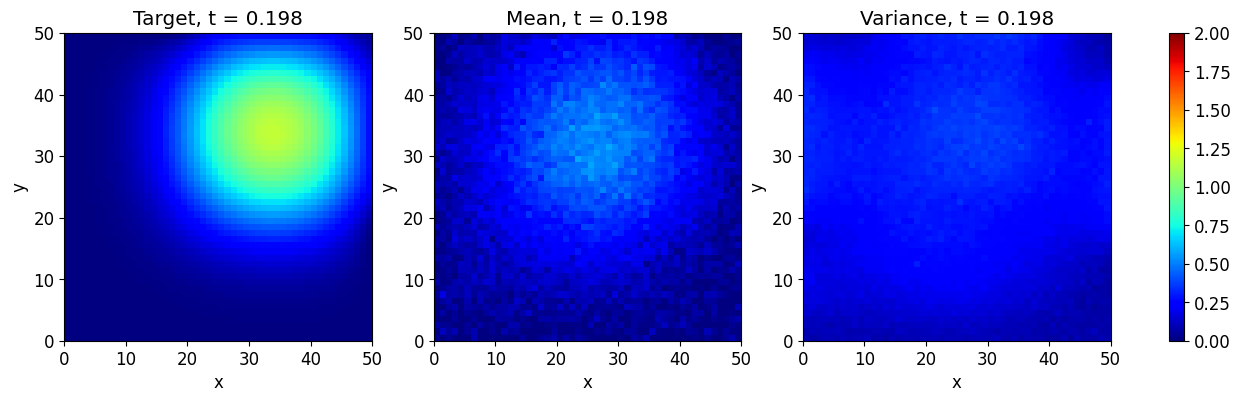




 CONV NP 



<Figure size 800x600 with 0 Axes>

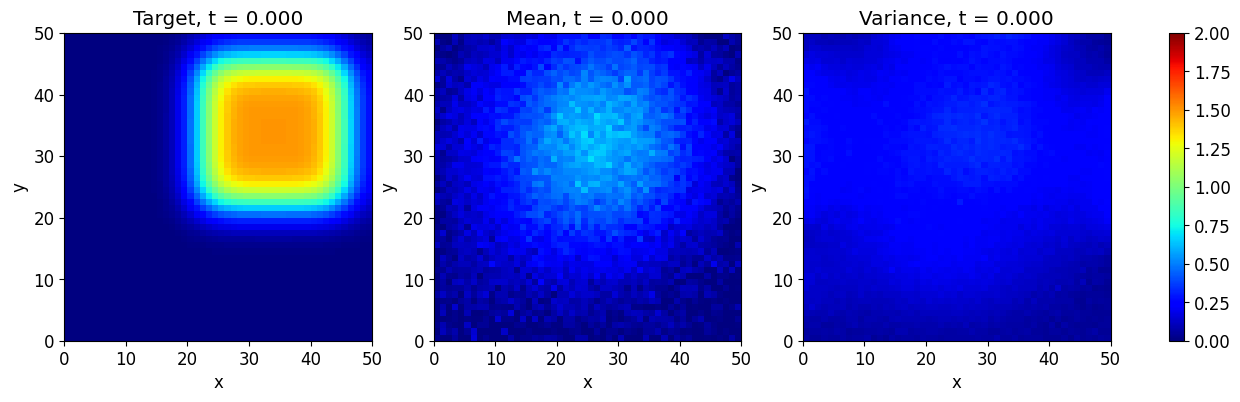




 CONV NP 



<Figure size 800x600 with 0 Axes>

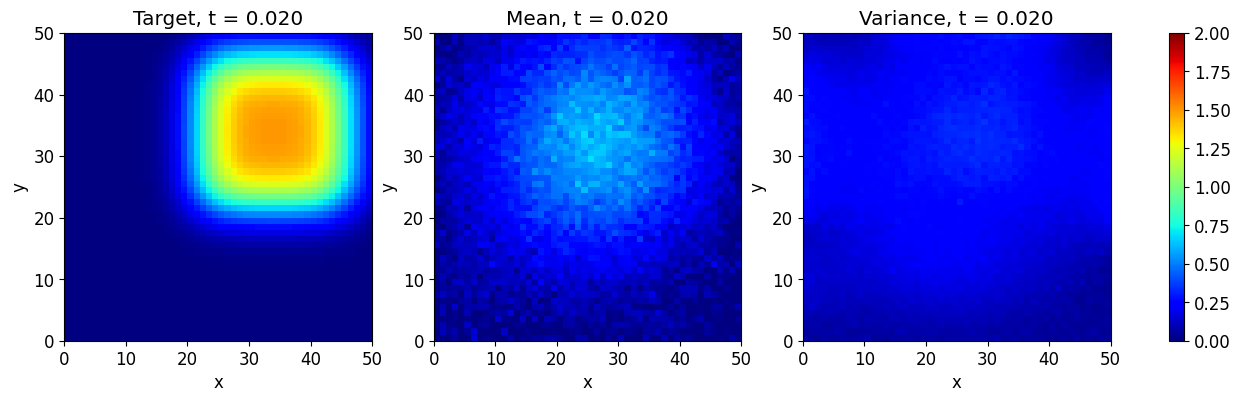




 CONV NP 



<Figure size 800x600 with 0 Axes>

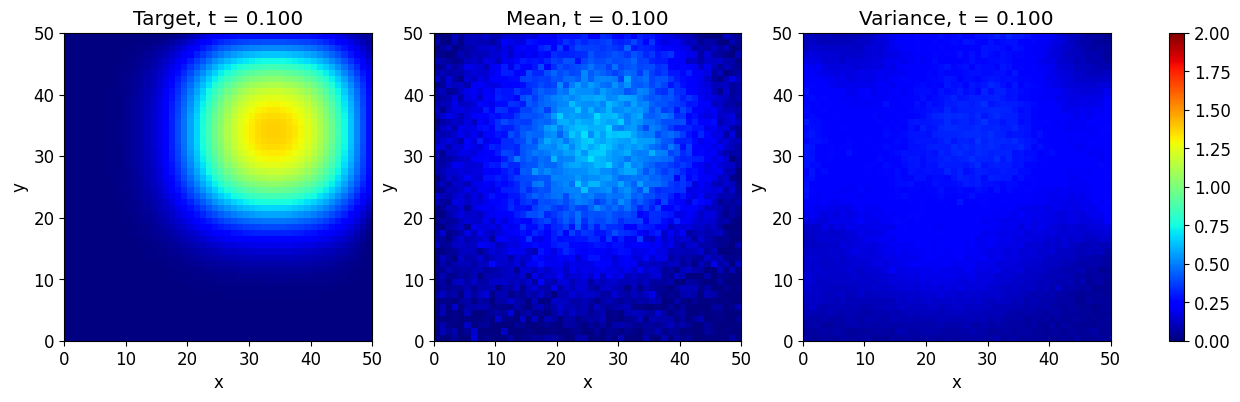




 CONV NP 



<Figure size 800x600 with 0 Axes>

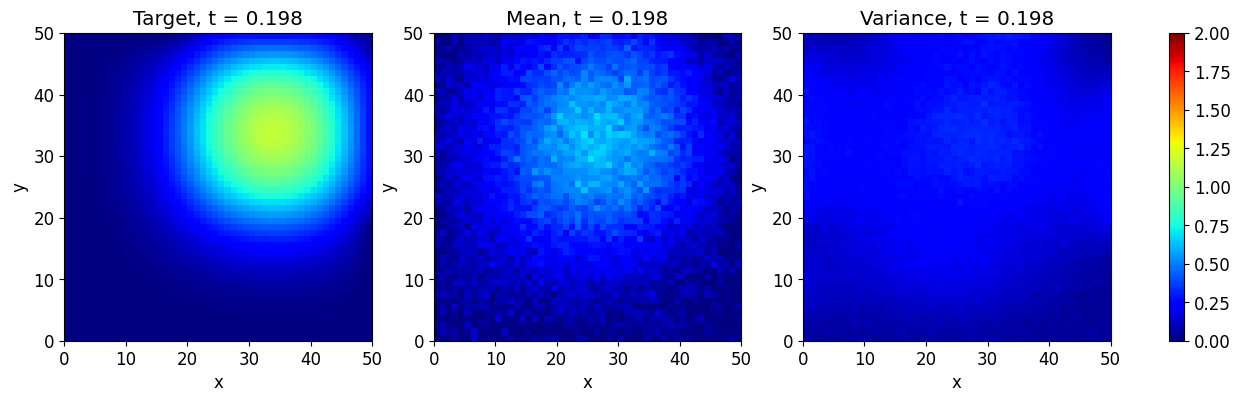

In [24]:
''' 
PLOTS SIDE BY SIDE:

        TARGET          MEAN            VARIANCE

FOR VARIOUS TIMES SPECIFIED IN THE LISTS
'''


for k in [0, 10, 50, 99]:
    print("FLAT NP \n")
    plotheatmap(result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n LUPI NP \n")
    plotheatmap(lupi_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(lupi_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)

for k in [0, 10, 50, 99]:
    print("\n\n\n CONV NP \n")
    plotheatmap(conv_result, k, dimensions['max_iter_time'], mean_var_only=False)
    # plotheatmap(conv_result_noise, k, dimensions['max_iter_time'], mean_var_only=True)
    



#### Metric 4: Plot Residuals and compare to Variance

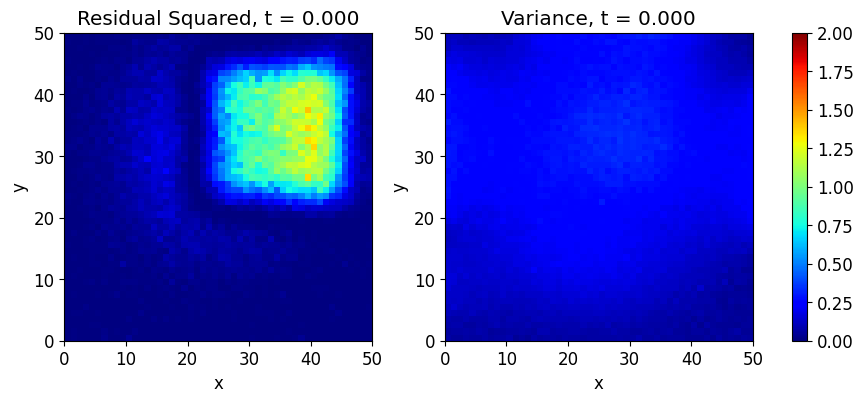

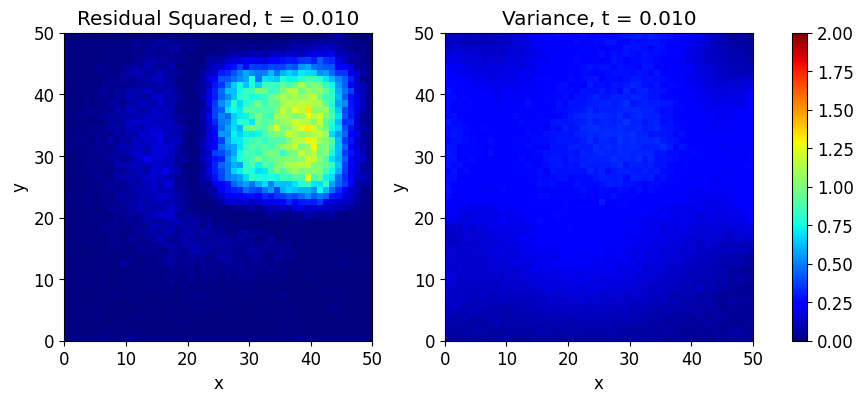

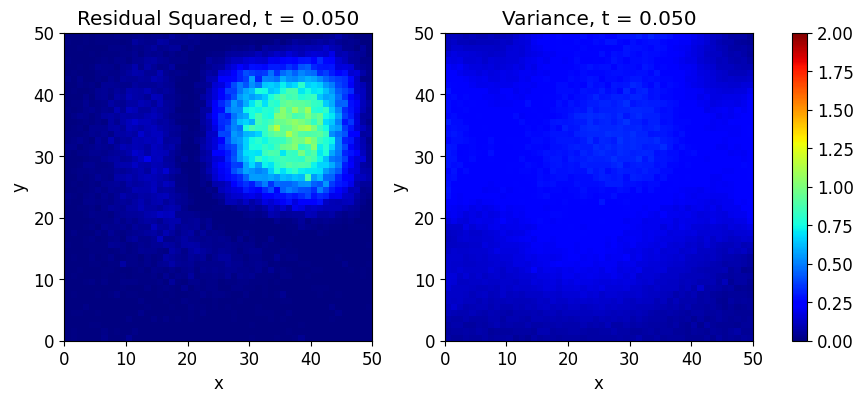

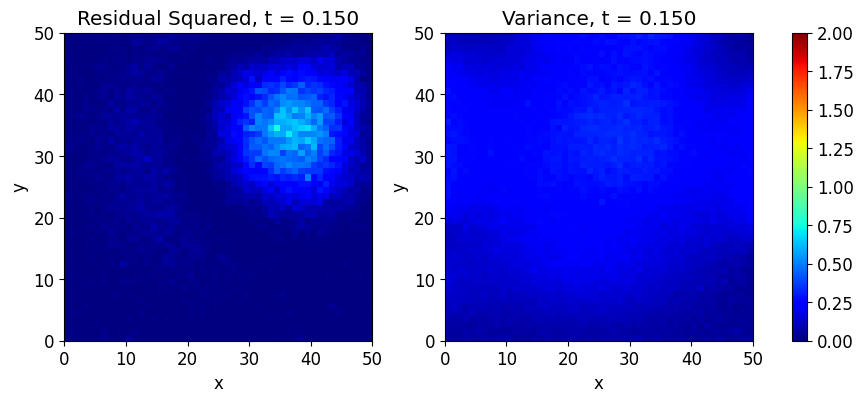

In [25]:
for i in [0, 5, 25, 75]:
    plot_residuals(conv_result, i, dimensions['max_iter_time'])

#### Noisey Input to Neural Process

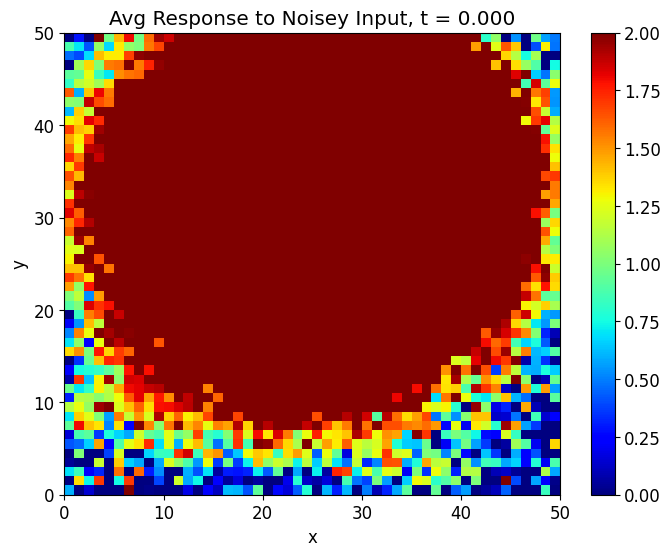

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [45]:
def plot_noisey_response(noise_output, time_iter, title=None):
    plt.xlabel("x")
    plt.ylabel("y")
    # This is to plot u_k (u at time-step k)
    plt.title("{}, t = {:.3f}".format(title, time_iter / noise_output.shape[0]))
    plt.pcolormesh(noise_output[time_iter], cmap=plt.cm.jet, vmin=0, vmax=2.0)
    plt.colorbar()
    plt.show()
    return plt

plot_noisey_response(lupi_result_noise, 0, 'NP Avg Response to Noisey Input')
plot_noisey_response(lupi_result_noise, 0, 'LUPI Avg Response to Noisey Input')
plot_noisey_response(lupi_result_noise, 0, 'Conv Avg Response to Noisey Input')


#### Heatmap Animation GIF

In [ ]:
"""
SINGLE HEATMAP GIF
------------------

- target = True, variance = False gives the target solution 
- target = False, variance = True gives the variance in the prediction
- target = False, variance = False gives the mean of the prediction
"""

def plot_and_save_heatmaps(noise: bool, architecture: str):
    ''' 
    Is there a way to plot this gif without defining a function inside a function?
    '''
    assert architecture in ['flat', 'LUPI', 'conv']

    if noise:
        for which_plot in ['Target', 'Mean', 'Variance']:

            def animate(k, max_iter_time: int, which_plot: str):
                single_hm(conv_result[k], k, dimensions['max_iter_time'], which_plot=which_plot)

            anim = FuncAnimation(
                plt.figure(),
                animate,
                interval=1,
                frames=dimensions['max_iter_time'],
                repeat=False,
                fargs=(dimensions['max_iter_time'], which_plot)
            )
            anim.save("./animation_results/noisey_{}_{}.gif".format(architecture, which_plot))
    else:
        for which_plot in ['Target', 'Mean', 'Variance']:

                def animate(k, max_iter_time: int, which_plot: str):
                    single_hm(conv_result[k], k, dimensions['max_iter_time'], which_plot=which_plot)

                anim = FuncAnimation(
                    plt.figure(),
                    animate,
                    interval=1,
                    frames=dimensions['max_iter_time'],
                    repeat=False,
                    fargs=(dimensions['max_iter_time'], which_plot)
                )
                anim.save("./animation_results/{}_{}.gif".format(architecture, which_plot))


plot_and_save_heatmaps(noise=False, architecture='conv')

#### Energy and Entropy 

In [ ]:
def get_energy_and_entropy(result):
    max_iter_time = len(result)
    grid_size = result[0][0].shape[0]
    avg_energy_target = torch.full((max_iter_time,), np.nan)
    avg_energy_mean = torch.full((max_iter_time,), np.nan)
    avg_energy_var = torch.full((max_iter_time,), np.nan)
    avg_entropy_target = torch.full((max_iter_time,), np.nan)
    avg_entropy_mean = torch.full((max_iter_time,), np.nan)
    avg_entropy_var = torch.full((max_iter_time,), np.nan)

    for k in range(max_iter_time):
        avg_energy_target[k] = torch.sum(result[k][0]) / (grid_size**2)
        avg_energy_mean[k] = np.sum(result[k][1]) / (grid_size**2)
        avg_energy_var[k] = np.sum(result[k][2]) / (grid_size**2)
        avg_entropy_target[k] = torch.count_nonzero(result[k][0]) / (grid_size**2)
        avg_entropy_mean[k] = np.count_nonzero(result[k][1]) / (grid_size**2)
        avg_entropy_var[k] = np.count_nonzero(result[k][2]) / (grid_size**2)

    return (
        (avg_energy_target, avg_energy_mean, avg_energy_var),
        (avg_entropy_target, avg_entropy_mean, avg_entropy_var),
    )
    
(
    (target_energy, mean_energy, var_energy),
    (target_entropy, mean_entropy, var_entropy),
) = get_energy_and_entropy(result)

(
    (lupi_target_energy, lupi_mean_energy, lupi_var_energy),
    (lupi_target_entropy, lupi_mean_entropy, lupi_var_entropy),
) = get_energy_and_entropy(lupi_result)

(
    (conv_target_energy, conv_mean_energy, conv_var_energy),
    (conv_target_entropy, conv_mean_entropy, conv_var_entropy),
) = get_energy_and_entropy(conv_result)

In [ ]:
def plot_energy(target, np_mean, lupi_mean, conv_mean, energy=True):
    fig = plt.figure()
    plt.axhline(color="black")
    plt.axvline(color="black")
    if energy:
        plt.title("Average Heat Energy in grid")
        plt.xlabel("Time")
        plt.ylabel("Average Energy")
    else:
        plt.title("Average Entropy ??(not quite)?? in grid")
        plt.xlabel("Time")
        plt.ylabel("Average Entropy")
    # plt.ticklabel_format(axis="both", style="sci", scilimits=(1, 1))
    if target is not None:
        plt.plot(target, label="Target", alpha=0.8)
    if np_mean is not None:
        plt.plot(np_mean, label= "NP", alpha=0.8)    
    if lupi_mean is not None:
        plt.plot(lupi_mean, label="LUPI", alpha=0.8)
    if conv_mean is not None:
        plt.plot(conv_mean, label="Conv", alpha=0.8)
    plt.legend()
    plt.grid()
    plt.show()

plot_energy(target_energy, mean_energy, lupi_mean_energy, conv_mean_energy)
plot_energy(target_entropy, mean_entropy, lupi_mean_entropy, conv_mean_entropy, energy=False)

# Fix this bug for GIF

In [ ]:
y_out = y_out.reshape((dimensions['max_iter_time'], grid_size, grid_size))
var_out = var_out.reshape((dimensions['max_iter_time'], grid_size, grid_size))
y_target = y_target.reshape((dimensions['max_iter_time'], grid_size, grid_size))

result = [
    (y_target[id, :, :], y_out[id, :, :], var_out[id, :, :])
    for id in range(y_target.shape[0])
]

# from heat_diffusion_dataset import Initial_Conditions, Diffusion_Data
# import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation


def plotheatmap(result_k, k, axes):
    # Clear the current plot figure
    plt.clf()
    ax1, ax2, ax3 = axes

    # plt.title(f"Temperature at t = {k * delta_t:.3f} unit time")
    ax1.set_title(f"Target at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time")
    ax1.set_xlabel("x")
    ax1.set_ylabel("y")

    ax2.set_title(
        f"Predicted Mean at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time"
    )
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")

    ax3.set_title(f"Predicted Var at t = {k * 4 * np.pi / dimensions['max_iter_time']:.3f} unit time")
    ax3.set_xlabel("x")
    ax3.set_ylabel("y")

    # This is to plot u_k (u at time-step k)
    ax1.pcolormesh(result_k[0], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)
    ax2.pcolormesh(result_k[1], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)
    ax3.pcolormesh(result_k[2], cmap=plt.cm.jet, vmin=-1.1, vmax=1.1)

    return fig, axes


def animate(k):
    plotheatmap(result[k], k)

    # if not plot_var and not target:
    #     plotheatmap(y_out[k], k, delta_t)
    # elif plot_var and not target:
    #     plotheatmap(var_out[k], k, delta_t)
    # else:
    #     plotheatmap(y_target[k], k, delta_t)


# plot_var = False
# target = False
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

anim = animation.FuncAnimation(
    fig, animate, interval=1, frames=dimensions['max_iter_time'], repeat=False, fargs=(axes,)
)
anim.save("harmonics_solution.gif")

# plot_var=True
# anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False, fargs=None)
# anim.save("harmonics_variance.gif")

# target=True
# anim = animation.FuncAnimation(plt.figure(), animate, interval=1, frames=max_iter_time, repeat=False, fargs=None)
# anim.save("harmonics_target.gif")